In [1]:
import os
os.listdir('/kaggle/input/isic-2018')

train_img_folder_path = "/kaggle/input/isic-2018/data/images/train"
train_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/train"
val_img_folder_path = "/kaggle/input/isic-2018/data/images/val"
val_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/val"
test_img_folder_path = "/kaggle/input/isic-2018/data/images/test"
val_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/test"

In [2]:
import tensorflow as tf
print("GPU devices:", tf.config.list_physical_devices('GPU'))
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))


GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
CUDA available: True
Device name: Tesla T4


In [3]:
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import matplotlib.pyplot as plt

os.listdir('/kaggle/input/isic-2018')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_img_folder_path = "/kaggle/input/isic-2018/data/images/train"
train_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/train"
val_img_folder_path = "/kaggle/input/isic-2018/data/images/val"
val_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/val"
test_img_folder_path = "/kaggle/input/isic-2018/data/images/test"
val_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/test"

# Improved model using UNet++ with ResNet50 as backbone
def UNetPlusPlus(input_shape=(256, 256, 3), num_classes=1):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Encoder blocks from ResNet50
    encoders = [
        base_model.get_layer("conv1_relu").output,
        base_model.get_layer("conv2_block3_out").output,
        base_model.get_layer("conv3_block4_out").output,
        base_model.get_layer("conv4_block6_out").output,
        base_model.get_layer("conv5_block3_out").output
    ]

    # Decoder block with skip connections for UNet++
    def conv_block(inputs, filters, kernel_size=3, activation='relu'):
        x = layers.Conv2D(filters, kernel_size, padding="same", activation=activation)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
        x = layers.BatchNormalization()(x)
        return x

    def upsample_block(inputs, skip, filters):
        x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(inputs)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    # Decoder layers
    x = encoders[-1]
    x = conv_block(x, 512)
    x = upsample_block(x, encoders[-2], 512)
    x = upsample_block(x, encoders[-3], 256)
    x = upsample_block(x, encoders[-4], 128)
    x = upsample_block(x, encoders[-5], 64)
    
    # Final upsampling to match input resolution
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(x)  # Ensure the output shape matches (256, 256, 1)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model

# Dice loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Custom data generator with augmentation
class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=16, target_size=(256, 256), shuffle=True, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.image_filenames = [f for f in sorted(os.listdir(image_dir)) if not f.endswith(('.txt'))]
        self.mask_filenames = [f for f in sorted(os.listdir(mask_dir)) if not f.endswith(('.txt'))]

        self.indexes = np.arange(len(self.image_filenames))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_filenames_temp = [self.image_filenames[k] for k in indexes]
        mask_filenames_temp = [self.mask_filenames[k] for k in indexes]
        images, masks = self._data_generation(image_filenames_temp, mask_filenames_temp)
        return images, masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _data_generation(self, image_filenames_temp, mask_filenames_temp):
        images, masks = [], []
        for img_file, mask_file in zip(image_filenames_temp, mask_filenames_temp):
            img_path = os.path.join(self.image_dir, img_file)
            mask_path = os.path.join(self.mask_dir, mask_file)
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img) / 255.0

            mask = load_img(mask_path, target_size=self.target_size, color_mode="grayscale")
            mask = img_to_array(mask) / 255.0
            mask = np.expand_dims(mask, axis=-1)

            if self.augment:
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)
                if np.random.rand() > 0.5:
                    img = np.flipud(img)
                    mask = np.flipud(mask)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Paths to data directories
train_img_folder_path = "/kaggle/input/isic-2018/data/images/train"
train_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/train"
val_img_folder_path = "/kaggle/input/isic-2018/data/images/val"
val_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/val"
test_img_folder_path = "/kaggle/input/isic-2018/data/images/test"
test_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/test"

# Instantiate Data Generators
train_gen = DataGenerator(
    train_img_folder_path,
    train_mask_folder_path,
    batch_size=16,
    target_size=(256, 256),  # Ensure this matches the model's output size
    augment=True
)

val_gen = DataGenerator(
    val_img_folder_path,
    val_mask_folder_path,
    batch_size=16,
    target_size=(256, 256),
    augment=False
)

test_gen = DataGenerator(
    test_img_folder_path,
    test_mask_folder_path,
    batch_size=16,
    target_size=(256, 256),
    augment=False
)

# Load model
model = UNetPlusPlus(input_shape=(256, 256, 3), num_classes=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy'])
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint("unetplusplus_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)
]
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

# Evaluate model
loss, accuracy = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")




Using device: cuda
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 48,670,017 (185.66 MB)

 Trainable params: 48,611,009 (185.44 MB)

 Non-trainable params: 59,008 (230.50 KB)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758272783.460394     101 service.cc:145] XLA service 0x7c4a980bd340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758272783.460483     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758272783.460487     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758272848.296610     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - accuracy: 0.8743 - loss: 0.2749 - val_accuracy: 0.7251 - val_loss: 0.9995 - learning_rate: 1.0000e-04
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9513 - loss: 0.1316 - val_accuracy: 0.7390 - val_loss: 0.9987 - learning_rate: 1.0000e-04
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9546 - loss: 0.1145 - val_accuracy: 0.7295 - val_loss: 0.9972 - learning_rate: 1.0000e-04
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9594 - loss: 0.1024 - val_accuracy: 0.7391 - val_loss: 0.6457 - learning_rate: 1.0000e-04
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9566 - loss: 0.1058 - val_accuracy: 0.8493 - val_loss: 0.3816 - learning_rate: 1.0000e-04
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9607 - loss: 0.0981 - val_accuracy: 0.8906 - val_loss: 0.2258 - learning_rate: 1.0000e-04
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.95

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


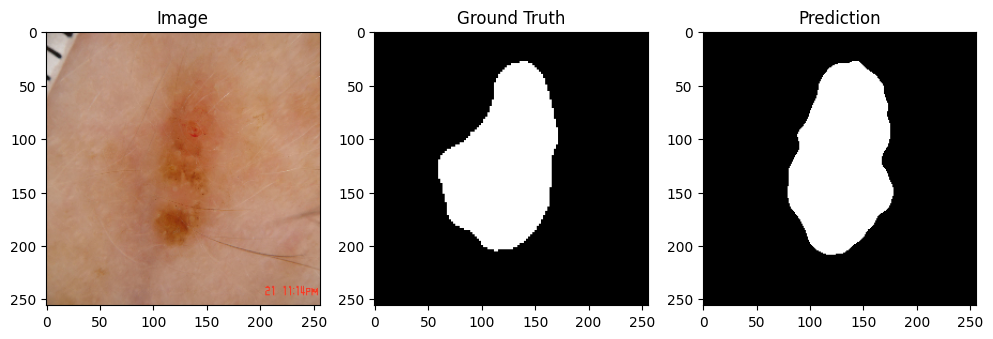

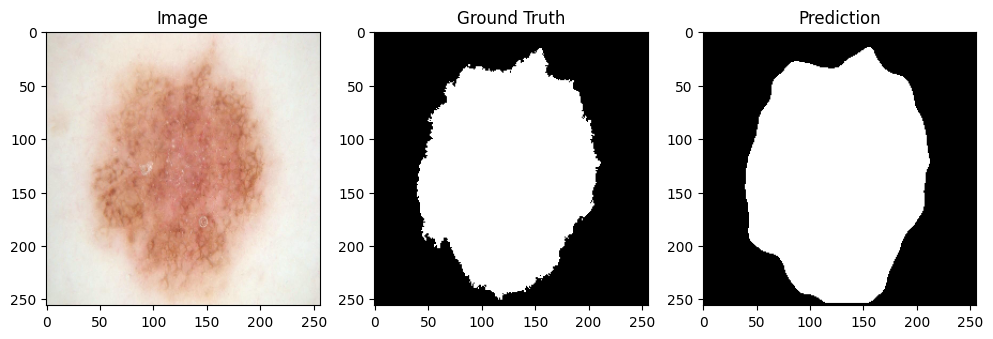

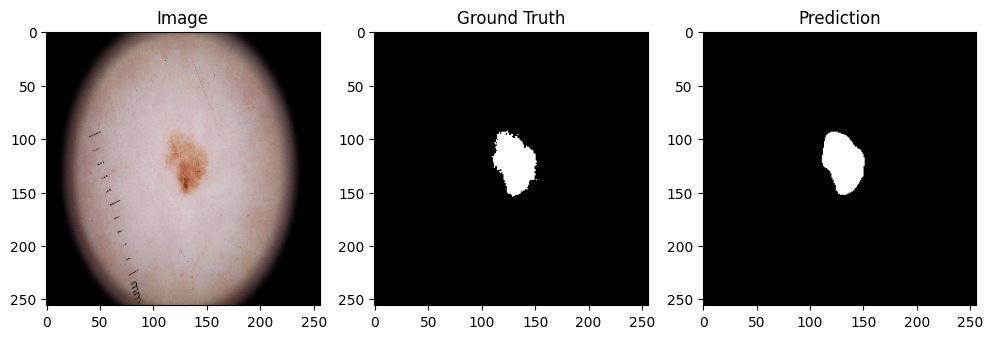

In [4]:
# Visualize predictions
def plot_predictions(data_gen, model, num_samples=5):
    images, masks = data_gen[0]   
    predictions = model.predict(images)

    num_samples = min(num_samples, len(images))   
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(images[i])

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[i].squeeze(), cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(predictions[i].squeeze() > 0.5, cmap="gray")
        plt.show()

# Example usage: show only 3 images
plot_predictions(test_gen, model, num_samples=3)


In [5]:
custom_img_path = "/kaggle/input/test-test/ISIC_0024306.jpg"
custom_mask_path = "/kaggle/input/test-test/ISIC_0024306_segmentation.png"
# Load image
img = load_img(custom_img_path, target_size=(256, 256))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)   # (1, 256, 256, 3)

# Load ground truth mask
mask = load_img(custom_mask_path, target_size=(256, 256), color_mode="grayscale")
mask_array = img_to_array(mask) / 255.0
mask_array = np.expand_dims(mask_array, axis=0)  # (1, 256, 256, 1)


In [6]:
pred = model.predict(img_array)
pred_mask = (pred[0, :, :, 0] > 0.5).astype(np.uint8)  # thresholded


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


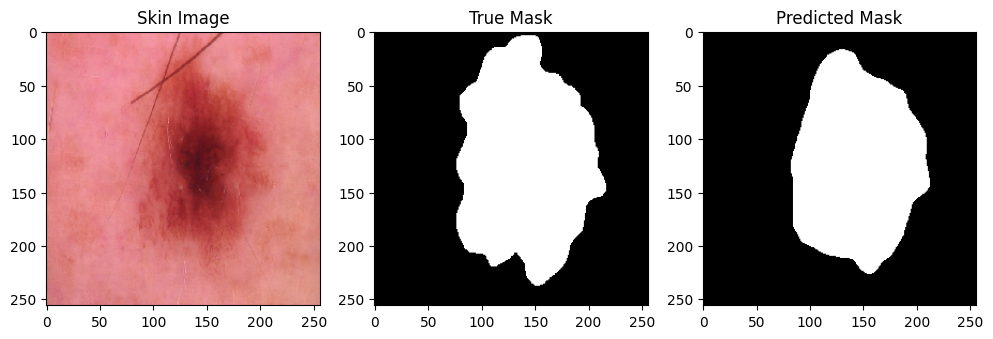

In [7]:
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Skin Image")
plt.imshow(img_array[0])

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(mask_array[0].squeeze(), cmap="gray")

# Predicted Mask
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap="gray")

plt.show()


In [8]:
loss, accuracy = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9357 - loss: 0.1166
Test Loss: 0.1105
Test Accuracy: 0.9372


In [9]:
# Redefine Dice and IoU as Keras metrics
dice_metric = tf.keras.metrics.Mean(name='dice_coef')
iou_metric = tf.keras.metrics.Mean(name='iou_coef')

def dice_coef_metric(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coef_metric(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Compile model with proper metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=['accuracy', dice_coef_metric, iou_coef_metric]
)


62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9305 - dice_coef_metric: 0.8801 - iou_coef_metric: 0.7873 - loss: 0.1199
Test Loss: 0.1101
Test Accuracy: 0.9373
Test Dice Coefficient: 0.8899
Test IoU: 0.8037


<Figure size 1200x400 with 0 Axes>

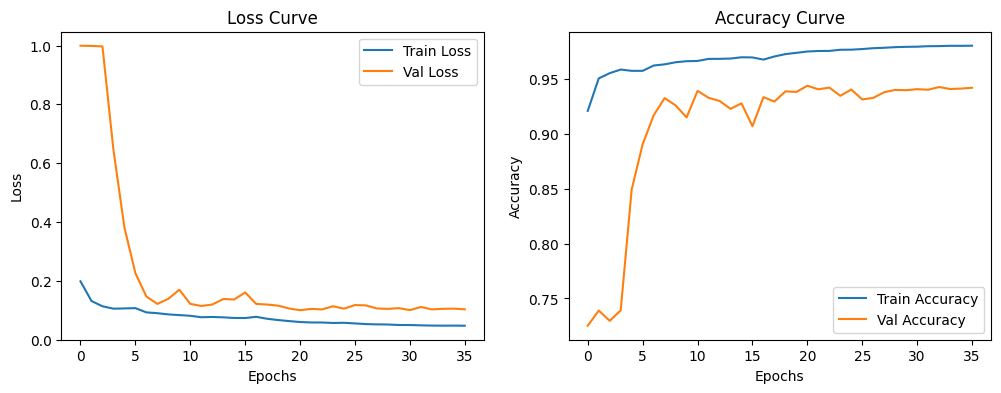

In [10]:


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

test_results = model.evaluate(test_gen)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Dice Coefficient: {test_results[2]:.4f}")
print(f"Test IoU: {test_results[3]:.4f}")

 
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
